In [1]:
IS_COLAB = True

We need to install these packages each time we run colab since they are not installed in the runtime evnironment. 

In [2]:
#install necessary libraries for distance and dimensionality reduction tasks
if IS_COLAB: 
    !pip install tcrdist3
    !pip install umap-learn
    !pip install umap-learn[plot]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.1/438.1 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.4/366.4 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for tcrdist3: filename=tcrdist3-0.2.2-py3-none-any.whl size=2100321 sha256=4fd96d1ef71c719dc037e27587cde1db33287fba2db3915a31fe1995165a9024
  Stored in directory: /root/.cache/pip/wheels/da/a2/13/eea7ee0b95b1f391f5559e8bc15459e27beb2abdc59d4fce0e
  Created wheel for feather-format: filename=feather_format-0.4.1-py3-none-any.whl size=2436 sha256=a614b5753f5e162a8a85a2df89

Mount drive if using colab

In [3]:
#Logic to mount drive if colab

if IS_COLAB:
    from google.colab import drive

    drive.mount('/content/drive')
    %ls
    %cd drive/MyDrive/dsmp-2024-groupol1/

Mounted at /content/drive
drive/  sample_data/
/content/drive/MyDrive/dsmp-2024-groupol1


Now we need to load the data. Within the VDJDB database there are several columns which are not relevant for our analysis and therefore we select a subset of columns. The main purpose of this notebook is establish distances between T-Cells based on alpha, beta and alpha-beta chains, therefore we are not concerned about T-Cells which do not bind to specific epitope, given by a score of 0, or including the same T-Cell more than once in our distance matrix. However we also include some other analysis of the dataset which poses questions for our downstream predidctive analysis

In [17]:
import pandas as pd
df = pd.read_csv('./data/vdjdb.txt', sep="\t")

selected_features = df[['gene','cdr3','v.segm','j.segm','species','mhc.a','mhc.b','mhc.class','antigen.epitope','antigen.species','vdjdb.score', 'complex.id']]

# Select all human data
human_data = selected_features[(selected_features['species'] == 'HomoSapiens') & (selected_features['vdjdb.score'] > 0)]

# Drop duplicate rows
human_data_cols = human_data.columns.difference(['complex.id', 'vdjdb.score'])
human_data = human_data.drop_duplicates(subset=human_data_cols)

# Delete rows with null values
human_data  = human_data.dropna()
# Print all data
human_data.head()


,gene,cdr3,v.segm,j.segm,species,mhc.a,mhc.b,mhc.class,antigen.epitope,antigen.species,vdjdb.score,complex.id
0,TRA,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2,1
1,TRB,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2,1
2,TRB,CASSFEAGQGFFSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2,0
3,TRA,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2,2
4,TRB,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2,2


In the following cell we see the same T-Cell beta chain sequence binding to different epitope. Since this demonstrates that T-Cells can bind to more than one antigen, it raises questions about how we should develop our model 

In [18]:
human_data[human_data['cdr3'] == 'CASSIRSSYEQYF']

,gene,cdr3,v.segm,j.segm,species,mhc.a,mhc.b,mhc.class,antigen.epitope,antigen.species,vdjdb.score,complex.id
1578,TRB,CASSIRSSYEQYF,TRBV19*01,TRBJ2-7*01,HomoSapiens,HLA-A*02:01:48,B2M,MHCI,GILGFVFTL,InfluenzaA,3,259
1582,TRB,CASSIRSSYEQYF,TRBV19*01,TRBJ2-7*01,HomoSapiens,HLA-A*02:01:48,B2M,MHCI,GILEFVFTL,synthetic,3,261
15131,TRB,CASSIRSSYEQYF,TRBV19*01,TRBJ2-7*01,HomoSapiens,HLA-A*02,B2M,MHCI,GILGFVFTL,InfluenzaA,1,0
19141,TRB,CASSIRSSYEQYF,TRBV19*01,TRBJ2-7*01,HomoSapiens,HLA-A*02:01,B2M,MHCI,GILGFVFTL,InfluenzaA,1,1219
20885,TRB,CASSIRSSYEQYF,TRBV19*01,TRBJ2-7*01,HomoSapiens,HLA-A*02:01,B2M,MHCI,GLCTLVAML,EBV,2,0
21478,TRB,CASSIRSSYEQYF,TRBV19*01,TRBJ2-1*01,HomoSapiens,HLA-A*02:01,B2M,MHCI,GILGFVFTL,InfluenzaA,1,0
26020,TRB,CASSIRSSYEQYF,TRBV19*02,TRBJ2-7*01,HomoSapiens,HLA-A*02:01,B2M,MHCI,GILGFVFTL,InfluenzaA,1,2608


We shall first establish a distance matrix using the Beta chain. We need to perform some rudimentary preprocessing before we can feed it in

In [5]:
TRB = human_data[human_data['gene'] =='TRB']
# rename the columns for our beta chain matrix calculation
beta_chains = TRB[['cdr3', 'v.segm', 'j.segm', 'antigen.epitope']]
beta_chains.rename(columns={'cdr3':'cdr3_b_aa','v.segm':'v_b_gene', 'j.segm':'j_b_gene'}, inplace=True)
beta_chains

<ipython-input-5-cdd9bf07a97a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beta_chains.rename(columns={'cdr3':'cdr3_b_aa','v.segm':'v_b_gene', 'j.segm':'j_b_gene'}, inplace=True)


,cdr3_b_aa,v_b_gene,j_b_gene,antigen.epitope
1,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,FLKEKGGL
2,CASSFEAGQGFFSNQPQHF,TRBV13*01,TRBJ1-5*01,FLKEKGGL
4,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,FLKEKGGL
6,CASSYEPGQVSHYSNQPQHF,TRBV13*01,TRBJ1-5*01,FLKEKGGL
8,CASSALASLNEQFF,TRBV14*01,TRBJ2-1*01,FLKEKGGL
...,...,...,...,...
92682,CASSLRATDTQYF,TRBV7-2*01,TRBJ2-3*01,PQPELPYPQPQL
92684,CATSRAGGGGEKLFF,TRBV15*01,TRBJ1-4*01,FPQPEQPFPWQP
92686,CASSQGSGGNEQFF,TRBV4-3*01,TRBJ2-1*01,FPQPEQPFPWQP
92690,CASSIVGSGGYNEQFF,TRBV19*01,TRBJ2-1*01,QLQPFPQPELPY


Here we create a function for calculating the pairwise distance matrix using TCRDist which we can reuse across alpha, beta and alpha-beta chains. Because of the high dimensionality of a single distance vector we look at dimensionality reduction methods to obtain a more compact representation of each T-Cell. We use UMAP to do this and then colour each point by the epitope they bind to. It is desirable for T-Cells to group into epitope distinct clusters. We only include T-Cells in the visualisation if they bind to one of the seven largest antigen groups within the dataset otherwise the visualisation would be difficult to interpret.

In [63]:
import os
from tcrdist.repertoire import TCRrep
import umap
import umap.plot

import numpy as np
import matplotlib.pyplot as plt

from typing import List

def calculate_dist_and_umap(df: pd.DataFrame,
                            chains: List[str],
                            gene: str) -> pd.DataFrame:
  """
  Function which calculates the T-Cell pairwise distance metric by alpha or beta
  chain using TCR dist and then uses UMAP to reduce dimensionality and outputs a
  plot coloured by epitope.
  
  """

  tr = TCRrep(cell_df = df,
            organism = 'human',
            chains = chains,
            db_file = 'alphabeta_gammadelta_db.tsv')

  if (len(chains)==1) and (chains[0] == 'beta'):
    distance_matrix = pd.concat([pd.DataFrame(tr.pw_cdr3_b_aa), tr.clone_df[gene]], axis = 1)
    chains = 'beta'
  elif (len(chains)==1) and (chains[0] == 'alpha'):
    distance_matrix = pd.concat([pd.DataFrame(tr.pw_cdr3_a_aa), tr.clone_df[gene]], axis = 1)
    chains = 'alpha'
  else:
    matrix = np.hstack((tr.pw_cdr3_b_aa, tr.pw_cdr3_a_aa))
    distance_matrix = pd.concat([pd.DataFrame(matrix), tr.clone_df[gene]], axis = 1)
    chains = 'alpha_beta'

  value_counts_antigen = distance_matrix[gene].value_counts()
  top_10_value_counts = value_counts_antigen.nlargest(7)
  distance_matrix_filtered = distance_matrix[distance_matrix[gene].isin(top_10_value_counts.index)]

  distances_reduced = umap.UMAP(n_components = 2, n_neighbors = 100, metric='hellinger').fit(distance_matrix_filtered.iloc[:, :-1].values)

  output_dir = 'visualisations'

  f = umap.plot.points(distances_reduced, labels=distance_matrix_filtered[gene])
  f.set_xlabel('UMAP Dimension 1', fontsize=10)
  f.set_ylabel('UMAP Dimension 2', fontsize=10)
  f.set_title(f'UMAP Visualization of {chains}', fontsize=12)

  # Save the figure
  if not os.path.exists(output_dir):
    os.makedirs(output_dir)

  f.get_figure().savefig(f'{output_dir}/{chains}_chain_umap.png')
  return distance_matrix

Now we obtain a low dimensionality representation of the beta chain which is visualised below. We see some evidence of clustering into T-Cells binding to same antigen in the middle left and middle right however from visual inspection it is not as effective as desired

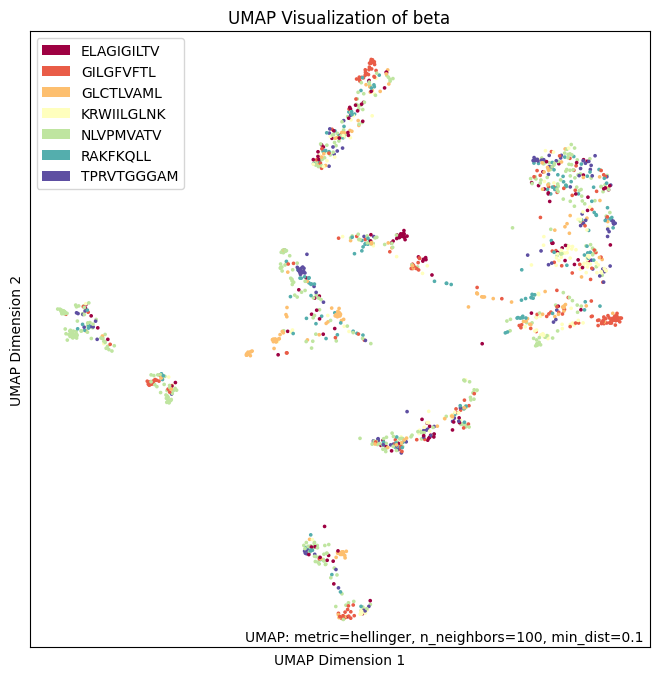

In [64]:
beta_dist_matrix = calculate_dist_and_umap(beta_chains, ['beta'], 'antigen.epitope')

We do the same for the alpha chain sequences for each T-Cell.

(2456, 4)


/usr/local/lib/python3.10/dist-packages/tcrdist/repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
/usr/local/lib/python3.10/dist-packages/tcrdist/repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")


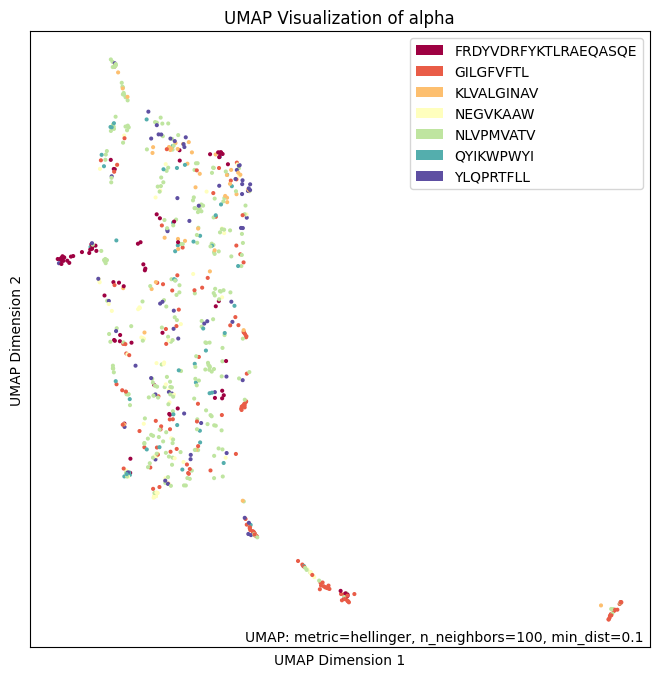

In [65]:
#prepare alpha chain and then input to function
TRA = human_data[human_data['gene'] =='TRA']

alpha_chains = TRA[['cdr3', 'v.segm', 'j.segm', 'antigen.epitope']].copy()
alpha_chains.rename(columns={'cdr3':'cdr3_a_aa','v.segm':'v_a_gene', 'j.segm':'j_a_gene'}, inplace=True)
print(alpha_chains.shape)
alpha_df = calculate_dist_and_umap(alpha_chains, ['alpha'], 'antigen.epitope')

For a single T-Cell we now look at obtaining a vector representation using the alpha and beta chains. 

In [66]:
alpha_chain = human_data[(human_data['gene'] == 'TRA') & (human_data['complex.id'] != 0)]
beta_chain = human_data[(human_data['gene'] == 'TRB') & (human_data['complex.id'] != 0)]

alpha_chain.rename(columns = {'cdr3':'cdr3_a_aa','v.segm':'v_a_gene', 'j.segm':'j_a_gene'}, inplace = True)
beta_chain.rename(columns = {'cdr3':'cdr3_b_aa','v.segm':'v_b_gene', 'j.segm':'j_b_gene'}, inplace = True)


<ipython-input-66-541f1e53464d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alpha_chain.rename(columns = {'cdr3':'cdr3_a_aa','v.segm':'v_a_gene', 'j.segm':'j_a_gene'}, inplace = True)
<ipython-input-66-541f1e53464d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beta_chain.rename(columns = {'cdr3':'cdr3_b_aa','v.segm':'v_b_gene', 'j.segm':'j_b_gene'}, inplace = True)


We are focused on T-Cells with an alpha and beta chain sequence within the VDJDB database hence we use an inner join. 

/usr/local/lib/python3.10/dist-packages/tcrdist/repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
/usr/local/lib/python3.10/dist-packages/tcrdist/repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")


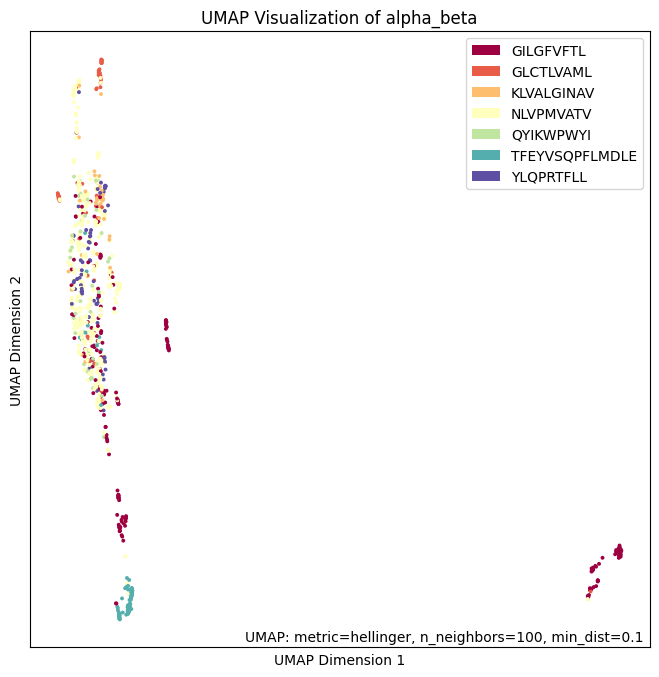

In [67]:
combined_chain = pd.merge(alpha_chain[['cdr3_a_aa', 'v_a_gene', 'j_a_gene', 'mhc.a', 'antigen.epitope', 'vdjdb.score', 'complex.id']].reset_index(drop = True),
                          beta_chain[['cdr3_b_aa', 'v_b_gene', 'j_b_gene', 'mhc.b', 'complex.id']].reset_index(drop = True),
                          how = 'inner',
                          on = 'complex.id')
_ = calculate_dist_and_umap(combined_chain, ['alpha', 'beta'], 'antigen.epitope')

# Embeddings using pretrained transformer 

We now look at another method for developing a representation of each amino acid sequence, specifically where we use a pretrained transformer model and extract the final latent representation from the model for each amino acid sequence. This approach has some fundamental differences to the TCRDist used earlier in the notebook. This provides advantages such as natively handling sequences of varying lengths and learning directly from the data. More about this is included in our report. 

In [ ]:
#move to GPU (if available)

import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
#instantiate model as pretrained transformer using weights from hugging face.

from transformers import BertModel, BertTokenizer
model_name = 'wukevin/tcr-bert'
model = BertModel.from_pretrained(model_name, add_pooling_layer=False).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


## Helper functions to get embedding from pretrained BERT model

Here we define some helper functions necessary for preprocessing of each amino acid sequence and tokenization

In [ ]:
from typing import  Sequence, Any
from math import floor


#special tokens
PAD = "$"
MASK = "."
UNK = "?"
SEP = "|"
CLS = "*"

def is_whitespaced(seq: str
                   ) -> bool:
    """
    This function detects whether there is whitespace between characters in an input string
    """
    tok = list(seq)
    spaces = [t for t in tok if t.isspace()]
    if len(spaces) == floor(len(seq) / 2):
        return True
    return False

def get_pretrained_bert_tokenizer(path: str
                                  ) -> BertTokenizer:
    """Get the pretrained BERT tokenizer. This is a character level tokenizer of amino acids within the beta chain"""
    tok = BertTokenizer.from_pretrained(
        path,
        do_basic_tokenize=False,
        do_lower_case=False,
        tokenize_chinese_chars=False,
        unk_token=UNK,
        sep_token=SEP,
        pad_token=PAD,
        cls_token=CLS,
        mask_token=MASK,
        padding_side="right",
    )
    return tok



def insert_whitespace(seq: str) -> str:
    """ 
    Inserts whitespace between each amino acid in a beta chain sequence. 
    """
    return " ".join(list(seq))

In [ ]:
model_tokenizer = get_pretrained_bert_tokenizer(model_name)

This method does not natively handle both the alpha and beta chains for a given TCR cell. We only use the beta chain to obtain the latent representation. 

In [ ]:
chains = beta_chains['cdr3_b_aa'].tolist()

 Here we compute a forward pass of the model and extract the embedding representation outputted by the final layer by computing the mean embedding across the first axis. Existing literature suggests that for the TRR-DIST model, that the layer chosen to extract the embedding representation is not important and that embedding representation will be similar across layers. We default to using the final layer

In [ ]:
from itertools import zip_longest
import numpy as np


#obtain embedding representation from last hidden layer
layers = [-1]

seqs = [s if is_whitespaced(s) else insert_whitespace(s) for s in chains]


chunks = seqs
chunks_pair = [None]
chunks_zipped = list(zip_longest(chunks, chunks_pair))
embeddings = []


#compute forward pass of model
with torch.no_grad():
      for seq_chunk in chunks_zipped:
          #tokenize input sequence
          encoded = model_tokenizer(
              *seq_chunk, padding="max_length", max_length=64, return_tensors="pt"
          )
          input_mask = encoded["attention_mask"].numpy()
          #move input to GPU
          encoded = {k: v.to(device) for k, v in encoded.items()}
          #forward pass
          x = model.forward(**encoded, output_hidden_states=True, output_attentions=True)
          for i in range(len(seq_chunk[0])):
                e = []
                for l in layers:
                    # Select the l-th hidden layer for the i-th example
                    h = (x.hidden_states[l][i].cpu().numpy().astype(np.float64))
                    if seq_chunk[1] is None:
                      seq_len = len(seq_chunk[0][i].split())
                    seq_hidden = h[1 : 1 + seq_len]
                    #obtain mean embedding from last hidden layer.
                    e.append(seq_hidden.mean(axis=0))

                e = np.hstack(e)
                assert len(e.shape) == 1
                embeddings.append(e)

#convert to np and stack embeddings 
if len(embeddings[0].shape) == 1:
    embeddings = np.stack(embeddings)
else:
    embeddings = np.vstack(embeddings)


# UMAP Dimensionality Reduction of TCR BERT

We reduce the dimensionality of the embeddings obtained from pretrained bidirectional encoder using UMAP and then visualise by antigen specificity. Want to see if embedding of t cells which bind to specific antigens are closely related and if clusters more distinct than using tcr dist

(1502, 769)


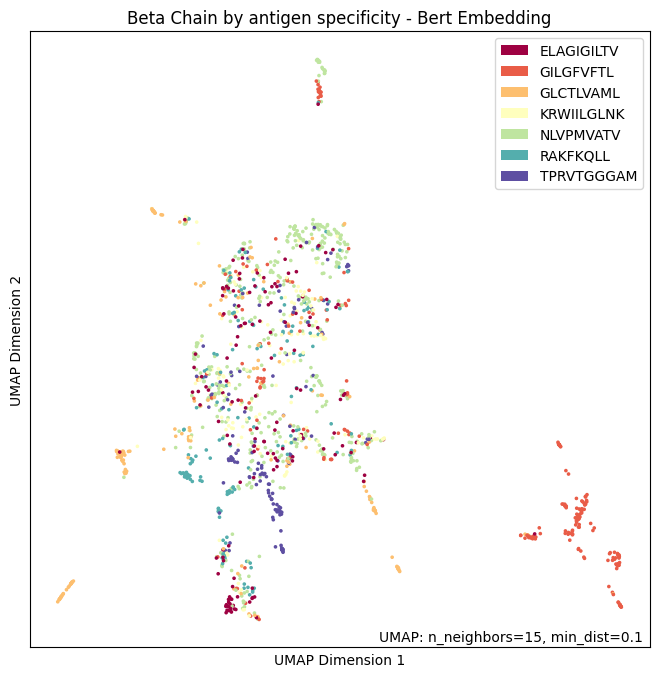

In [ ]:
beta_chains.reset_index(inplace= True)
#concatenate embeddings with antigens
embedding_df = pd.concat([pd.DataFrame(embeddings), beta_chains['antigen.epitope']], axis = 1)
value_counts_antigen = embedding_df['antigen.epitope'].value_counts()
#we will only visualise the top 7 most commonly occuring antigens in dataset else visualisation would be uninterpretable
top_10_value_counts = value_counts_antigen.nlargest(7)
embedding_df_filtered = embedding_df[embedding_df['antigen.epitope'].isin(top_10_value_counts.index)]
distances_reduced = umap.UMAP(n_components = 2).fit(embedding_df_filtered.iloc[:, :-1].values)
distances_reduced

## Plot
output_dir = 'visualisations'
f = umap.plot.points(distances_reduced, labels=embedding_df_filtered['antigen.epitope'])
f.set_xlabel('UMAP Dimension 1', fontsize=10)
f.set_ylabel('UMAP Dimension 2', fontsize=10)
f.set_title(f'Beta Chain by antigen specificity - Bert Embedding', fontsize=12)
f.get_figure().savefig(f'{output_dir}/beta_chain_umap_bert.png')


# PCA and then TSNE

Given the high dimensionality of both the distance matrix and embedding representation, reducing dimensions using TSNE is computationally unfeasible. However we can apply PCA to reduce the dimensionality to 50, and then compute TSNE on this reduce representation. This of interest since one of the main advantages of TSNE is that it preserves local distance very effectively which makes it effective for downstream clustering/predictive task

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


#reducing embeddings from 768 to the 50 components which preserve the most variance in the dataset
PCA_model = PCA(n_components = 50)
embedding_pca = PCA_model.fit_transform(embedding_df.iloc[:, :-1].values)
#apply TSNE on 50 components.
TSNE_model = TSNE(n_components=2, perplexity=30.0)
embedding_pca_tsne = TSNE_model.fit_transform(embedding_pca)




In [ ]:
#similar preprocessing to obtain final low dimensional representation of TSNE embedding representation
embedding_tsne_df = pd.DataFrame(np.concatenate((embedding_pca_tsne, embedding_df['antigen.epitope'].values.reshape(-1, 1)),
                                                axis =1),
                                 columns = ['DIM_1', 'DIM_2', 'Epitope'])

epitope_val_count = embedding_tsne_df['Epitope'].value_counts()
top_10_value_counts = epitope_val_count.nlargest(7)
embedding_tsne_filtered = embedding_tsne_df[embedding_tsne_df['Epitope'].isin(top_10_value_counts.index)]

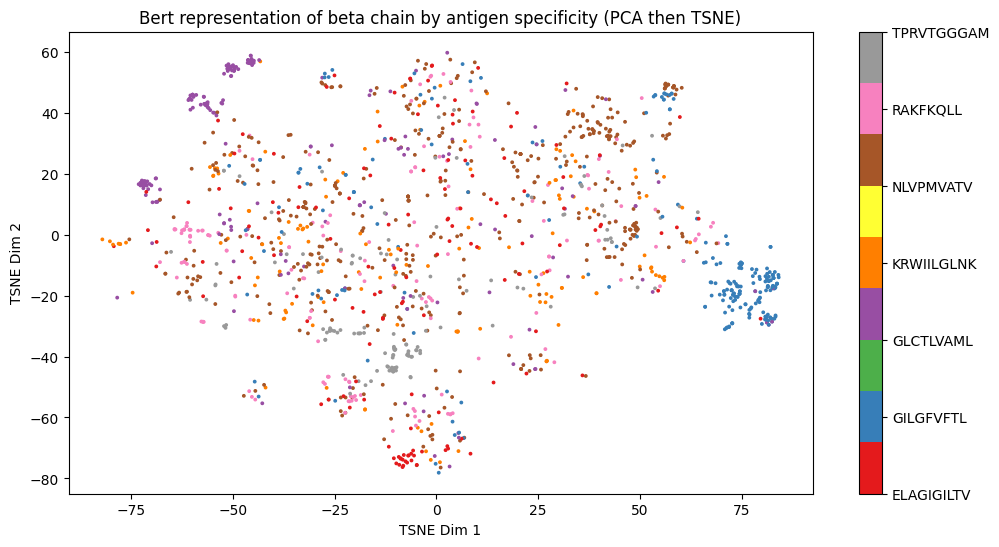

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

#plot by antigen spec -> have to obtain numerical representations of antigens to visualise
#in this way
plt.figure(figsize=(12, 6))
epitope_category = pd.Categorical(embedding_tsne_filtered['Epitope'])
epitope_codes = epitope_category.codes
epitope_labels = epitope_category.categories
colormap = matplotlib.colormaps.get_cmap('Set1')

sc = plt.scatter(embedding_tsne_filtered['DIM_1'],
                 embedding_tsne_filtered['DIM_2'],
                 c=epitope_codes,
                 s=3,
                 cmap = colormap)

cbar = plt.colorbar(sc, ticks=np.arange(len(epitope_labels)))
cbar.set_ticklabels(epitope_labels)


plt.xlabel('TSNE Dim 1')
plt.ylabel('TSNE Dim 2')
plt.title('Bert representation of beta chain by antigen specificity (PCA then TSNE)')
plt.savefig(f'{output_dir}/beta_chain_tsne_pca.png')
plt.show()

# Distances for paired alpha and beta pairs

In [ ]:
# Let's get all the IDs for the TCRs (A & B pairs should have the same ID)
_ids = human_data['complex.id']
_ids

list_to_combine = []
checked_ids = []
def process_row(row):
    # check the complex id not already checked
    if row['complex.id'] not in checked_ids:
        # find matching rows
        matched_rows = human_data[human_data['complex.id'] == row['complex.id']]
        # should be two (some rows have only 1 match)
        if len(matched_rows) == 2:
            # get the tcra row
            tra_row = matched_rows.iloc[0]
            # get the tcrb row
            trb_row = matched_rows.iloc[1]
            # add to list as a combined row
            list_to_combine.append({'tcr_id_a':tra_row['complex.id'], 'tcr_id_b':trb_row['complex.id'],
                                    'cdr3_a_aa': tra_row['cdr3'], 'cdr3_b_aa': trb_row['cdr3'],
                                    'v_b_gene' :trb_row['v.segm'],
                                    'j_b_gene':trb_row['j.segm'],
                                    'v_a_gene':tra_row['v.segm'],
                                    'j_a_gene':tra_row['j.segm'],
                                   })
            # we've checked this id now, so we need to make sure we don't have to check it again.
            checked_ids.append(row['complex.id'])
human_data.apply(process_row, axis=1)

In [ ]:
# Create table representing paired tcr rows
paired_table = pd.DataFrame(list_to_combine)
paired_table

# Get paired distances

tr_paired = TCRrep(cell_df = paired_table,
            organism = 'human',
            chains = ['alpha','beta'],
            db_file = 'alphabeta_gammadelta_db.tsv')

# get alpha chain distance calculations for paired tcrs and print them.
paired_matrix_alpha_chain = tr_paired.pw_alpha
paired_alpha_distances = pd.DataFrame(paired_matrix_alpha_chain)
paired_alpha_distances

# get beta chain distance calculations for paired tcrs and print them.
paired_matrix_beta_chain = tr_paired.pw_beta
paired_beta_distances = pd.DataFrame(paired_matrix_beta_chain)
paired_beta_distances